In [20]:
import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import os

import torch

from scipy.io import loadmat

from tqdm import tqdm_notebook as tqdm

In [21]:
# https://www.somersault1824.com/wp-content/uploads/2015/02/color-blindness-palette-e1423327633855.png
cbcolors={1:(0,0,0),
          2:(0,73,73),
          3:(0,146,146),
          4:(255,109,182),
          5:(255,182,119),
          6:(73,0,146),
          7:(0,109,219),
          8:(182,109,255),
          9:(109,182,255),
          10:(182,219,255),
          11:(146,0,0),
          12:(146,73,0),
          13:(219,209,0),
          14:(36,255,36),
          15:(255,255,109)}
cbcolors={k:(v[0]/255,v[1]/255,v[2]/255) for k,v in cbcolors.items()}

In [22]:
%matplotlib inline

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [43]:
#plot='baselines'
plot='variants'

In [62]:
if plot=='baselines':
    methods = ['hesaff',
               'hesaffnet', 
               'delf', 
               'superpoint',
               'd2-net',
               'r2d2',
               'ncnet.sparsencnet_3200_hard_soft_1k']
    
    names = ['Hes. Aff. + Root-SIFT',
             'HAN + HN++', 
             'DELF',
             'SuperPoint',
             'D2-Net Trained', 
             'R2D2',
             'Sparse-NCNet, hard+soft, r=3200']
    
    colors=[cbcolors[3],
            cbcolors[14],
            cbcolors[7],
            cbcolors[10],
            cbcolors[4],
            cbcolors[8],
            cbcolors[1]]
                
    linestyles = ['--', '--', '-', '-.',
                  '-.', '-', '-']
    
    markers = ['^','o','|','s','x','v','']

    plot_name='hseq_ncnet_vs_baselines'
    
elif plot=='variants':
    methods = ['ncnet.sparsencnet_800_noreloc_2k',
               'ncnet.densencnet_800_noreloc_2k',
               'ncnet.sparsencnet_1600_hard_2k',
               'ncnet.densencnet_1600_hard_2k',
               'ncnet.sparsencnet_1600_hard_soft_2k',
               'ncnet.sparsencnet_3200_hard_soft_2k']
    
    names = ['Sparse-NCNet, r=800',
             'NCNet, r=800',
             'Sparse-NCNet, hard, r=1600',
             'NCNet, hard, r=1600',
             'Sparse-NCNet, hard+soft, r=1600',
             'Sparse-NCNet, hard+soft, r=3200']

    markers = ['^','o','|','s','x','']
    
    colors=[cbcolors[3],
            cbcolors[14],
            cbcolors[7],
            cbcolors[10],
            cbcolors[4],
            cbcolors[1]]
                
    linestyles = ['--', '--', '-.', '-.',
                  '-', '-', '-', '-']
    
    plot_name='hseq_ncnet_variants'


In [63]:
# Change here if you want to use top K or all features.
top_k = 2000

In [64]:
n_i = 52
n_v = 56

In [65]:
base_path = '../datasets/hpatches/'
dataset_path = os.path.join(base_path,'hpatches-sequences-release')

In [66]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [67]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [68]:
def benchmark_features_ncnet(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        for im_idx in range(2, 7):
            keypoints_a, keypoints_b = read_feats(seq_name, im_idx)            

            if im_idx==2:
                n_feats.append(keypoints_a.shape[0])
            n_feats.append(keypoints_b.shape[0])

            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a
            pos_a_h = np.concatenate([pos_a, np.ones([pos_a.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(keypoints_a.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [69]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a[matches[:, 0], : 2]             
            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]
            
            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [70]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )

In [71]:
def generate_read_function(method, extension='ppm'):
    if method.startswith('ncnet'):
        def read_function_ncnet(seq_name, im_idx):
            aux = np.load(os.path.join(dataset_path, seq_name, '{}_{}.npz'.format(1,im_idx)+method[5:]))
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints_A'][ids, :], aux['keypoints_B'][ids, :]
        return read_function_ncnet
    else:
        def read_function(seq_name, im_idx):
            aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
            if top_k is None:
                return aux['keypoints'], aux['descriptors']
            else:
                assert('scores' in aux)
                ids = np.argsort(aux['scores'])[-top_k :]
                return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
        return read_function

In [72]:
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]

In [73]:
if top_k is None:
    cache_dir = os.path.join(base_path,'cache')
else:
    cache_dir = os.path.join(base_path,'cache-top')

if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)


In [74]:
errors = {}

In [75]:
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        read_function = generate_read_function(method)
    if method.startswith('ncnet'):
        benchmark_function=benchmark_features_ncnet
    else:
        benchmark_function=benchmark_features
    if os.path.exists(output_file):        
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_function(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

ncnet.sparsencnet_800_noreloc_2k
Loading precomputed errors...
# Features: 2000.000000 - [2000, 2000]
# Matches: Overall 2000.000000, Illumination 2000.000000, Viewpoint 2000.000000
ncnet.densencnet_800_noreloc_2k
Loading precomputed errors...
# Features: 2000.000000 - [2000, 2000]
# Matches: Overall 2000.000000, Illumination 2000.000000, Viewpoint 2000.000000
ncnet.sparsencnet_1600_hard_2k
Loading precomputed errors...
# Features: 2000.000000 - [2000, 2000]
# Matches: Overall 2000.000000, Illumination 2000.000000, Viewpoint 2000.000000
ncnet.densencnet_1600_hard_2k
Loading precomputed errors...
# Features: 2000.000000 - [2000, 2000]
# Matches: Overall 2000.000000, Illumination 2000.000000, Viewpoint 2000.000000
ncnet.sparsencnet_1600_hard_soft_2k
Loading precomputed errors...
# Features: 2000.000000 - [2000, 2000]
# Matches: Overall 2000.000000, Illumination 2000.000000, Viewpoint 2000.000000
ncnet.sparsencnet_3200_hard_soft_2k
Loading precomputed errors...
# Features: 2000.000000 - [

# Plotting

In [76]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

In [77]:
len(linestyles)

8

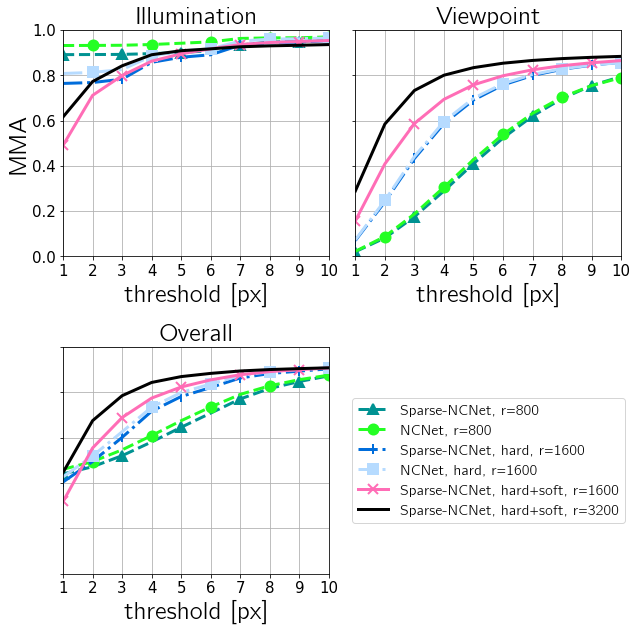

In [78]:
font = {'fontname':'CMU Bright'}

plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)
#plt.rc('text', usetex=True)
plt.rc('text', usetex=False)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
for i, (method, name, color, ls, ms) in enumerate(zip(methods, names, colors, linestyles, markers)):
    i_err, v_err, _ = errors[method]
    if i%2==0:
        me = 2
    else:
        me=(1,2)
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name, marker=ms, markersize=10, markevery=me, markeredgewidth=2)
plt.title('Illumination',**font)
plt.xlabel('threshold [px]',**font)
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA',**font)
plt.ylim([0, 1])
#plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2, 2, 2)
for i, (method, name, color, ls, ms) in enumerate(zip(methods, names, colors, linestyles, markers)):
    i_err, v_err, _ = errors[method]
    if i%2==0:
        me = 2
    else:
        me=(1,2)
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name, marker=ms, markersize=10, markevery=me, markeredgewidth=2)
    
plt.title('Viewpoint',**font)
plt.xlabel('threshold [px]',**font)
plt.xlim(plt_lim)
plt.xticks(plt_rng)
#plt.ylabel('MMA',**font)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2, 2, 3)
for i, (method, name, color, ls, ms) in enumerate(zip(methods, names, colors, linestyles, markers)):
    i_err, v_err, _ = errors[method]
    if i%2==0:
        me = 2
    else:
        me=(1,2)
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name, marker=ms, markersize=10, markevery=me, markeredgewidth=2)
plt.title('Overall',**font)
plt.xlabel('threshold [px]',**font)
plt.xlim(plt_lim)
plt.xticks(plt_rng)
#plt.ylabel('MMA',**font)
plt.ylim([0, 1])
plt.gca().set_yticklabels("")
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2, 2, 4)
for i, (method, name, color, ls, ms) in enumerate(zip(methods, names, colors, linestyles, markers)):
    i_err, v_err, _ = errors[method]
    plt.plot([], [], color=color, ls=ls, linewidth=3, label=name, marker=ms, markersize=10, markevery=me, markeredgewidth=2)
plt.axis('off')
plt.legend(loc='center',prop={'size': 15, 'family':'CMU Bright'})

plt.subplots_adjust(hspace=0.4,wspace=0.1)

plt.show()